## **Undirected Chinese Postman Problem (UCPP)**
**Course:** Graph Theory & Social Networks 

 **Author:** Jakub Błaszczyk 250380


### **Imports**

In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from queue import PriorityQueue, deque
from copy import deepcopy
import random
from functools import lru_cache
import math

### **Classes `Graph` and `WeightedGraph` provided during the laboratories**

In [2]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self, directed = 0):
      """
      Plots the graph using networkx package.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()


    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def random_bipartite_graph(m, n, p):
        """
        Creates a random bipartite graph G(m, n, p) model.
        m: number of vertices in the first partition.
        n: number of vertices in the second partition.
        p: probability of an edge between vertices from different partitions.
        """
        bipartite_graph = Graph()
        for i in range(1, m + n + 1):
            bipartite_graph.add_vertex(i)

        for u in range(1, m + 1):
            for w in range(m + 1, m + n + 1):
                if random() < p:
                    bipartite_graph.add_edge([u, w])
        return bipartite_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v, visited=None):
        """
        Performs a pre-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            print(v, end=" ")
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.preorder(neighbor, visited)

    def postorder(self, v, visited=None):
        """
        Performs a post-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.postorder(neighbor, visited)
            print(v, end=" ")

    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by the vertex set V.
        """
        subgraph = Graph()
        for v in V:
            subgraph.add_vertex(v)
            for w in self.graph[v]:
                if w in V:
                    subgraph.add_arc([v, w])
        return subgraph


    def ConnectedComponentsGraphs(self):
        """
        Returns a list of graphs, where each graph represents a connected component.
        Uses the existing connected_components method to find vertex sets.
        """
        components_vertex_sets = self.connected_components()
        list_of_component_graphs = []

        for component_set in components_vertex_sets[1:]:
            component_graph = Graph()
            for u in component_set:
                #component_graph.add_vertex(u)              # more general and elegant
                #for v in self.graph[u]:
                #  component_graph.add_arc([u, v])
                component_graph.graph[u] = self.graph[u]    # simply does the same stuff
            list_of_component_graphs.append(component_graph)

        return list_of_component_graphs

    def distance(self, v):
      """
      Computes the distance from vertex v to all other reachable vertices in the graph.
      It uses the BFS approach.
      Result is given as a dictionary of distances.
      """
      dist = {v: 0}     # starting point of a dictionary
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:     # w not visited already
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def GeneralisedDFS(self):
      """
      DFS with a timer.
      """
      global timer

      def DFS(v):
        """
        Internal DFS
        """
        global timer
        visited[v] = timer
        for u in self.graph[v]:
          if u not in visited:
            timer += 1
            DFS(u)
        processed[v] = timer

      timer = 0
      visited = {}
      processed = {}
      for v in self.graph:
        if v not in visited:
          DFS(v)
      return visited, processed

    def TopologicalSort2(self):
      """
      Returns a list of vertices in topological order:
      Lecture version, without checking acyclicity
      """
      ordering = {}
      vis, pro = self.GeneralisedDFS()
      for v in self.graph:
        ordering[v] = pro[v]*len(self.graph) - vis[v]
      order = sorted(ordering, key=ordering.get, reverse=True)

      return ordering, order

In [3]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    #redefinition of printing and plotting
    def __str__(self):
        res = ""
        #res = super().__str__()
        #res += '-------------------------\n'
        for v in self.graph:
            res += f'{v}: '
            for u in self.graph[v]:
                res += f'{u}({self.weights[(v, u)]}) '
            res += '\n'
        return res

    def plot(self, directed = 0):
      """
      Plots the graph using networkx package.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      nx.set_edge_attributes(G, self.weights, 'weight')
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True, node_color='lightblue')
      edge_labels = nx.get_edge_attributes(G, 'weight')

      if directed:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.25)
      else:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
      plt.show()

    # Modyfying graphs
    def del_vertex(self, v):
      """
      Removes a vertex from the graph.
      """
      # TODO - should be done in a different way
      super().del_vertex(v)

    def add_arc(self, arc, weight = 1):
       """
       Given pair of vertices (arc variable) add an arc to the graph
       We consider simple, directed graphs.
       """
       super().add_arc(arc)
       u, v = arc
       self.weights[(u, v)] = weight

    def add_edge(self, edge, weight = 1):
       """
       Given pair of vertices (edge variable) add an edge to existing graph.
       We consider simple, undirected graphs, as symmetric digraphs without loops.
       """
       super().add_edge(edge)
       u, v = edge
       self.weights[(u, v)] = weight
       self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        When we have at least 3 words we assume the third one is an edge weight (of type int).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = WeightedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # exactly two words, unweghted edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
          elif len(words) >= 3:             # at least three words, weighted edge description
            if directed:
              graph.add_arc([words[0], words[1]], int(words[2]))
            else:
              graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
      """
      Computes a minimum spanning tree using Jarnik - Prim's algorithm.
      """
      for v in self.graph:    # choose any vertex of a graph
        break
      wtree = WeightedGraph()
      wtree.add_vertex(v)
      total_weight = 0
      q = PriorityQueue()
      for w in self.graph[v]:
        q.put((self.weights[(v, w)], v, w))
      while not q.empty():
        weight, u, v = q.get()
        if v not in wtree.graph:
          wtree.add_edge([u, v], weight)
          total_weight += weight
          for w in self.graph[v]:
            if w not in wtree.graph:
              q.put((self.weights[(v, w)], v, w))
      if len(wtree.graph) != len(self.graph):
        print("The graph is not connected! Returned is a spanning tree of some component.")
      return total_weight, wtree


    def Dijkstra(self, s):
      """
      Computes the shortest path from vertex s to all other reachable vertices in the graph.
      It uses the Dijkstra approach.
      Result is given as a dictionary of distances.
      """
      # initialization
      dist = {}     # distance dictionary
      pred = {}     # predecessors dictionary
      for v in self.graph:
        dist[v] = float('inf')
        pred[v] = None
      dist[s] = 0
      queue = PriorityQueue()
      queue.put((0, s))
      while not queue.empty():
        d, u = queue.get()
        if dist[u] < d:
          continue
        for v in self.graph[u]:
          # relaxation
          if dist[v] > dist[u] + self.weights[(u, v)]:
            dist[v] = dist[u] + self.weights[(u, v)]
            pred[v] = u
            queue.put((dist[v], v))
      return dist, pred

    def BellmanFord(self, s):
        """
        Bellman–Ford algorithm. Computes shortest paths from source s and detects negative-weight cycles.
        """
        dist = {v: float('inf') for v in self.graph} # all distances start as +∞
        pred = {v: None for v in self.graph} # predecessor dictionary
        dist[s] = 0
        vertices = list(self.graph.keys())
        n = len(vertices)
        for _ in range(n): # relax all edges|V|-1 times
            updated = False
            for u in self.graph: # iterate over all edges u → v
                for v in self.graph[u]:
                    w = self.weights[(u, v)] # weight
                    if dist[u] + w < dist[v]: # relaxation condition (better path)
                        dist[v] = dist[u] + w
                        pred[v] = u
                        updated = True # update happened
            if not updated:
                break

        has_negative_cycle = updated # check for negative-weight cycles
        return dist, pred, has_negative_cycle


    def network_flow(self):
      """
      Return the network flow (a graph with backward arcs) computed from original digraph.
      """
      network = WeightedGraph()
      for v in self.graph:
        network.add_vertex(v)
      for v in self.graph:
        for u in self.graph[v]:
          network.add_edge([v, u], 0)
      for xx in self.weights:
        network.weights[xx] = self.weights[xx]
      return network

    def MaxFlow_EK(self, s, t):
      """
      Computes the maximum flow from vertex s to vertex t using the Edmonds–Karp algorithm.
      Flow is returned as a dictionary of arc weights.
      """
      network = self.network_flow()
      flow = {xx: 0 for xx in network.weights}
      # compute the augmenting paths
      while True:
        pred ={s: None}   # dictionary of predecessors
        cap = {s: np.inf}   # dictionary of capacities
        queue = [s]
        # BFS starts
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (v not in pred) and (network.weights[(u, v)] - flow[(u, v)] > 0):
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
        if t in pred:
          # process the augmenting path
          v = t
          c = cap[t]
          while v != s:
            u = pred[v]
            flow[(u, v)] += c
            flow[(v, u)] -= c
            v = u
        else: # there is no augmenting path - the end
          break
      return flow
    
    
    
    def hungarian_algorithm(self, X, Y):
      """
      Implementation of the Hungarian algorithm.
      X: Set of row vertices (Left partition)
      Y: Set of column vertices (Right partition)
      """
      u = {}
      for i in X:
          max_w = 0
          for j in Y:
              w = self.weights.get((i, j), 0)
              if w > max_w:
                  max_w = w
          u[i] = max_w

      v = {j: 0 for j in Y}

      M = {}

      while True:
          G_eq = {node: set() for node in X}

          for i in X:
              for j in Y:
                  if (i, j) in self.weights:
                      w = self.weights[(i, j)]
                      if abs(u[i] + v[j] - w) < 1e-9:
                          G_eq[i].add(j)

          M, Q = maximum_matching(G_eq, X, Y, M)

          if len(M) == 2 * len(X):
              final_matching = {k: val for k, val in M.items() if k in X}
              return final_matching, u, v

          R = X & Q
          T = Y & Q

          epsilon = float('inf')

          uncovered_X = X - R
          uncovered_Y = Y - T

          for i in uncovered_X:
              for j in uncovered_Y:
                  if (i, j) in self.weights:
                      w = self.weights[(i, j)]
                      excess = u[i] + v[j] - w
                      if excess < epsilon:
                          epsilon = excess

          if epsilon == float('inf'):
              print("Error: Graph is disconnected or invalid.")
              return M, u, v

          for i in uncovered_X:
              u[i] -= epsilon
          for j in T:
              v[j] += epsilon




### **1. Introduction**

The **Chinese Postman Problem (CPP)** is a classical problem in graph theory motivated by real-world routing tasks such as mail delivery, street sweeping, or garbage collection. The goal is to find a shortest closed walk that traverses every edge of a graph at least once.

In this project we study the **undirected version** of the Chinese Postman Problem on **weighted graphs**. 

The solution combines several fundamental graph-theoretic concepts:

- Eulerian graphs and vertex degrees

- Single-source shortest paths (Dijkstra algorithm)

- Pairing odd-degree vertices

- Prüfer codes for trees

All implementations are based on the `Graph` and `WeightedGraph` classes provided during the course.

### **2. Theoretical Background**
#### **2.1 Eulerian Graphs**

An undirected graph is **Eulerian** if it is connected and **all vertices have even degree**. In this case, there exists an Euler circuit, i.e. a closed walk that uses every edge exactly once.

- If a graph is Eulerian → the CPP solution is trivial

- If a graph has vertices of odd degree → edges must be duplicated

#### **2.2 Undirected Chinese Postman Problem**

Given a connected undirected weighted graph:

**1.** Find all vertices of odd degree

**2.** Compute shortest paths between them

**3.** Pair odd vertices so that the total added distance is minimal

**4.** Duplicate the corresponding shortest paths

**5.** The resulting graph is Eulerian

The minimal total cost is:

    (sum of all edge weights) + (minimum added cost)

#### **2.3 Single-Source Shortest Paths**

To compute distances between odd-degree vertices, we use **Dijkstra’s algorithm**, which computes the shortest paths from a fixed source vertex to all other vertices in a weighted graph with non-negative weights.

#### **2.4 Prüfer Codes**

A **Prüfer code** is a sequence of length $n - 2$ that uniquely represents a labeled tree with  $n$ vertices.

Properties:
- One-to-one correspondence between trees and Prüfer codes
- Useful for encoding tree structures

In this project, Prüfer codes are applied to shortest-path trees obtained from Dijkstra’s algorithm.

### **3. Helper Functions**

All helper functions below are based directly on the `Graph` and `WeightedGraph` classes prepared and used during the classes. No external graph implementations are used; the functions only extend or combine the provided methods.

#### **3.1 Vertex Degrees**

In [4]:
def vertex_degrees(G):
    deg = {}
    for v in G.graph:
        deg[v] = len(G.graph[v])
    return deg

#### **3.2 Odd-Degree Vertices**

In [5]:
def odd_vertices(G):
    deg = vertex_degrees(G)
    return [v for v in deg if deg[v] % 2 == 1]

#### **3.3 Total Edge Weight**

In [6]:
def total_edge_weight(G):
    return sum(G.weights.values()) // 2

### **4. Shortest Paths Between Odd Vertices**
In the Chinese Postman algorithm we need distances **between odd-degree vertices**. To obtain them, we run **Dijkstra’s algorithm** once from each odd vertex. The result is a dictionary-of-dictionaries `dist` such that `dist[u][v]` equals the length of the shortest path from `u` to `v`.

This information is later used in **Section 6** to compute the additional cost needed to pair odd vertices.

For each odd-degree vertex, we run Dijkstra’s algorithm.

In [7]:
def odd_vertices_distances(G, odd):
    dist = {}
    for v in odd:
        d, _ = G.Dijkstra(v)
        dist[v] = d
    return dist

### **5. Greedy Minimum Matching**
Once all pairwise shortest-path distances between odd vertices are known (Section 4), we must **pair** the odd vertices. Each pair represents a shortest path that will be duplicated to make all degrees even.

The function below implements a **simple greedy matching**: it repeatedly takes one odd vertex and pairs it with the closest remaining odd vertex. While this is not guaranteed to be globally optimal in all cases, it is sufficient for demonstration purposes and small/medium examples, and it clearly shows the idea of the algorithm.

This function is used **directly in Section 6**.

To pair odd-degree vertices, we use a greedy algorithm. While not optimal in all cases, it is sufficient for demonstration purposes and small graphs. This greedy approach is not guaranteed to be globally optimal, but it is sufficient for demonstrating the idea of the algorithm.

In [8]:
def greedy_matching(odd, dist):
    odd = odd.copy()
    cost = 0
    while odd:
        v = odd.pop(0)
        u = min(odd, key=lambda x: dist[v][x])
        cost += dist[v][u]
        odd.remove(u)
    return cost

### **6. Chinese Postman Algorithm**
The function `chinese_postman_undirected(G)` implements the **undirected Chinese Postman Problem (UCPP)**.

What happens step by step:

1. We find all odd-degree vertices using the helper functions.

2. We compute the base cost = sum of all edge weights.

3. If there are no odd vertices, the graph is Eulerian and the answer is simply the base cost.

4. Otherwise:

    - We compute shortest-path distances between odd vertices (using Section 4).

    - We pair odd vertices using greedy matching (Section 5).

    - The sum of these paired distances is the extra cost needed to make the graph Eulerian.
5. The final result is:

`total cost = (sum of all edges) + (extra matching cost)`

In [9]:
def chinese_postman_undirected(G):
    odd = odd_vertices(G)                
    base_cost = total_edge_weight(G)      

    if len(odd) == 0:                     
        print("Graph is Eulerian")
        return base_cost

    print("Odd-degree vertices:", odd)
    dist = odd_vertices_distances(G, odd) 
    extra_cost = greedy_matching(odd, dist) 

    return base_cost + extra_cost         


### **7. Example**

In this section we construct a **small weighted undirected graph**, compute the Chinese Postman cost for it, and visualize the graph.

1: 2(3) 4(1) 3(5) 
2: 1(3) 3(2) 
3: 2(2) 4(4) 1(5) 
4: 3(4) 1(1) 

Odd-degree vertices: [1, 3]
Chinese Postman cost: 20


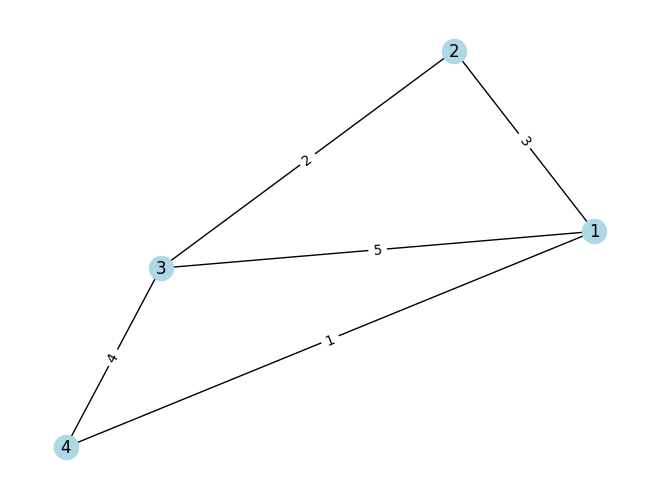

In [10]:
G = WeightedGraph()
G.add_edge([1, 2], 3)
G.add_edge([2, 3], 2)
G.add_edge([3, 4], 4)
G.add_edge([4, 1], 1)
G.add_edge([1, 3], 5)

print(G)                              # Show graph edges and weights
print("Chinese Postman cost:", chinese_postman_undirected(G)) # Compute UCPP cost
G.plot()                              # Visualize the graph


### **8. Prüfer Code of a Shortest-Path Tree**

In this section we show how **Prüfer codes** can be applied to a tree obtained from the graph.

First, we run Dijkstra’s algorithm from a chosen start vertex. Besides distances, Dijkstra also returns a **predecessor dictionary** `pred`, which describes a **shortest-path tree** rooted at the start vertex.

From this predecessor dictionary we explicitly **construct the corresponding tree** as a `Graph` object. This tree contains exactly the edges that form the shortest paths from the root to all other reachable vertices.

Finally, we apply the `Prufer()` method to this tree to compute its **Prüfer code**.

What this demonstrates:

- Dijkstra’s algorithm does not only compute distances, but also defines a **tree structure**

- Every tree can be encoded uniquely by a **Prüfer code**

- This shows how shortest-path trees can be **encoded and represented compactly**

In [11]:
dist, pred = G.Dijkstra(1)


T = Graph()
for v in pred:
    if pred[v] is not None:
        T.add_edge([v, pred[v]])


print("Prüfer code of shortest-path tree:", T.Prufer())

Prüfer code of shortest-path tree: 1 1


Step-by-step explanation of the code:

1. `G.Dijkstra(1)` computes shortest paths from vertex `1` and stores, for each vertex, its predecessor in the shortest-path tree.

2. We create an empty graph `T`, which will represent the shortest-path tree.

3. For every vertex `v`, if `pred[v]` is not `None`, we add the edge `(v, pred[v])` to `T`.

4. The resulting graph `T` is a tree.

5. We compute and print its Prüfer code using `T.Prufer()`.

### **9. Matching via Matrix Representation (Additional Remark)**

In some implementations of the Chinese Postman Problem, especially when pairing odd-degree vertices, the problem can be reduced to a **minimum/maximum weight matching** problem on a complete graph of odd vertices.

A matrix-based approach can be used to represent pairwise distances or costs. For example, a weighted bipartite graph constructed from a cost matrix can be solved using the **Hungarian algorithm**.

The following code fragment illustrates how a matrix representation may be transformed into a weighted bipartite graph and solved via a matching algorithm:

In [12]:
def maximum_matching(G, X, Y, M):
    """
    G : dict {x: set of neighbors in Y} (adjacency list))
    X : set; left partition of the bipartite graph
    Y : set; right partition of the bipartite graph
    M : dict representing matching (both directions)
    Returns M — Maximum matching and Q — Minimum vertex cover
    """
    def MX():
        return {x for x in X if x in M}

    def MY():
        return {y for y in Y if y in M}

    # U := X \ MX
    U = X - MX()

    while True:
        # S := U; T := ∅
        S = set(U)
        T = set()
        imp = 0
        pred = {}              # predecessors
        queue = deque()

        # insert queue ← u for u ∈ U
        for u in U:
            queue.append(u)

        while queue:
            u = queue.popleft()
            # for v ∈ N(u) \ T
            for v in G.get(u, set()) - T:

                if v in MY():
                    # v saturated — enlarge alternating path
                    pred[v] = u
                    x = M[v]

                    if x not in S:
                        queue.append(x)
                        S.add(x)
                        T.add(v)

                else:
                    # v not saturated — augmenting path found
                    x = u
                    curr_v = v

                    while x in MX():
                        y = M[x]
                        M[x] = curr_v
                        M[curr_v] = x
                        del M[y]
                        del M[x]
                        curr_v = y
                        x = pred[y]
                    M[x] = curr_v
                    M[curr_v] = x
                    U.remove(x)
                    imp = 1
                    break
            if imp == 1:
                break
        if imp == 0:
            break

    # Q := T ∪ (X \ S)
    Q = T | (X - S)

    return M, Q

In [13]:
matrix_data = [
[7, 2, 5, 1, 4],
[3, 6, 2, 8, 5],
[4, 1, 7, 3, 6],
[5, 4, 6, 2, 7],
[2, 8, 3, 6, 1]
]


wg = WeightedGraph()


rows = [f"R{i}" for i in range(len(matrix_data))]
cols = [f"C{j}" for j in range(len(matrix_data[0]))]
X = set(rows)
Y = set(cols)


for r_idx, r_node in enumerate(rows):
    for c_idx, c_node in enumerate(cols):
        wg.add_arc((r_node, c_node), matrix_data[r_idx][c_idx])


matching, u_final, v_final = wg.hungarian_algorithm(X, Y)


print("Maximum Weight Matching Results:")
total_weight = 0
for r in sorted(list(X)):
    if r in matching:
        c = matching[r]
        w = wg.weights[(r, c)]
        total_weight += w
        print(f" {r} -> {c} (Weight: {w})")

print(f"Total Maximum Weight: {total_weight}")

Maximum Weight Matching Results:
 R0 -> C0 (Weight: 7)
 R1 -> C3 (Weight: 8)
 R2 -> C2 (Weight: 7)
 R3 -> C4 (Weight: 7)
 R4 -> C1 (Weight: 8)
Total Maximum Weight: 37


This approach is conceptually related to the pairing of odd-degree vertices in the Chinese Postman Problem, where the goal is to minimize the additional traversal cost.

**Attribution note.** The matrix-based matching code shown above was prepared by **Yurii Zaika** as part of his final project. It is included here for educational purposes and to demonstrate an alternative matching-based approach consistent with the material covered during the course.

### **10. Conclusion**

In this project we implemented the undirected Chinese Postman Problem using classical graph algorithms. The solution combines Eulerian graph theory, single-source shortest paths, greedy and matching-based pairing strategies, and Prüfer codes. All implementations rely
on the provided `Graph` and `WeightedGraph` classes, demonstrating their versatility in solving complex graph problems.

### **11. Remarks after first submission – Optimal vs Greedy Matching in CPP**

#### 11.1. Limitation of the greedy matching approach

In the initial version of the project, a greedy heuristic was used to match odd-degree vertices in the Chinese Postman Problem.
Although this approach is fast and simple, it does not guarantee optimality. In particular, greedy matching may choose locally
optimal pairs which block globally better solutions.

Therefore, in this section we extend the project by implementing an exact minimum weight perfect matching algorithm and compare
its results with the greedy heuristic.

#### 11.2. Optimal matching and Hungarian algorithm

In Section 9, the Hungarian algorithm for solving the assignment problem in bipartite graphs was implemented.
Although the Chinese Postman Problem requires solving a minimum weight perfect matching problem, this problem
can be reformulated as an assignment problem by duplicating the set of odd-degree vertices.

Thus, the Hungarian algorithm implementation from Section 9 can be reused to compute an optimal pairing of odd vertices.



In [14]:
def optimal_matching_cost(dist_matrix):
    """
    Exact minimum weight perfect matching using DP over bitmasks.
    Works for small number of odd vertices (<=20).
    """
    n = len(dist_matrix)

    @lru_cache(None)
    def dp(mask):
        if mask == 0:
            return 0

        # take first available vertex
        i = (mask & -mask).bit_length() - 1
        best = math.inf

        mask_without_i = mask ^ (1 << i)
        j_mask = mask_without_i

        while j_mask:
            j = (j_mask & -j_mask).bit_length() - 1
            new_mask = mask_without_i ^ (1 << j)

            cost = dist_matrix[i][j] + dp(new_mask)
            best = min(best, cost)

            j_mask ^= (1 << j)

        return best

    full_mask = (1 << n) - 1
    return dp(full_mask)


#### 11.3. Reformulation of the matching problem as an assignment problem

In [15]:
def cpp_matching_with_hungarian(odd_vertices, distances):
    """
    Uses Hungarian algorithm from Section 9 to compute optimal pairing of odd vertices.
    """

    # build artificial bipartite graph
    left = [f"L{i}" for i in range(len(odd_vertices))]
    right = [f"R{i}" for i in range(len(odd_vertices))]

    wg = WeightedGraph()

    for i in range(len(odd_vertices)):
        for j in range(len(odd_vertices)):
            if i == j:
                continue  # forbid self-match
            u = odd_vertices[i]
            v = odd_vertices[j]
            cost = distances[u][v]

            # we want MIN cost, Hungarian is MAX → negate
            wg.add_arc((left[i], right[j]), -cost)

    X = set(left)
    Y = set(right)

    matching, _, _ = wg.hungarian_algorithm(X, Y)

    used = set()
    total_cost = 0

    for l in matching:
        r = matching[l]
        i = int(l[1:])
        j = int(r[1:])

        if i in used or j in used:
            continue

        used.add(i)
        used.add(j)

        total_cost += distances[odd_vertices[i]][odd_vertices[j]]

    return total_cost


#### 11.4. Integration with the CPP solver

In this subsection, all three methods are applied to the same graph instance and their results are compared.

In [31]:
# build distance matrix for odd vertices
odd = odd_vertices(G)

# compute distances between odd vertices using existing function
distances = odd_vertices_distances(G, odd)

k = len(odd)

dist_matrix = [[0]*k for _ in range(k)]
for i in range(k):
    for j in range(k):
        dist_matrix[i][j] = distances[odd[i]][odd[j]]

# compute matching costs using three methods
greedy_cost = greedy_matching(odd, distances)   # <<< TU JEST POPRAWKA
optimal_dp_cost = optimal_matching_cost(dist_matrix)
hungarian_cost = cpp_matching_with_hungarian(odd, distances)

print("Matching cost comparison on the main test graph:")
print("Greedy matching cost:      ", greedy_cost)
print("Optimal DP matching cost:  ", optimal_dp_cost)
print("Hungarian matching cost:   ", hungarian_cost)

print()
print("CPP total cost comparison:")
print("CPP cost (greedy):   ", total_edge_weight(G) + greedy_cost)
print("CPP cost (optimal):  ", total_edge_weight(G) + optimal_dp_cost)
print("CPP cost (hungarian):", total_edge_weight(G) + hungarian_cost)



Matching cost comparison on the main test graph:
Greedy matching cost:       5
Optimal DP matching cost:   5
Hungarian matching cost:    5

CPP total cost comparison:
CPP cost (greedy):    20
CPP cost (optimal):   20
CPP cost (hungarian): 20


#### 11.5. Results for the main test graph

For the main test graph used in this project, all three methods produce exactly the same result.
The greedy matching heuristic, the Hungarian-algorithm-based method, and the exact dynamic programming algorithm
all return the same matching cost and the same final Chinese Postman Problem cost.

This confirms that for this particular graph instance, the greedy heuristic is sufficient and achieves the optimal solution.
The optimal methods serve here as a verification of the correctness and optimality of the greedy result.


#### 11.6. A counterexample where the greedy matching fails

In this subsection, a specially constructed graph is used to demonstrate that the greedy matching heuristic
does not guarantee an optimal solution. Although greedy matching makes locally optimal choices, it may block
a globally better pairing configuration.

The following example shows a case where the greedy result is strictly worse than the optimal solution
computed using the Hungarian-based method and the exact dynamic programming algorithm.


In [51]:
# Construct a small artificial graph where greedy matching fails

# We directly define distances between 4 odd vertices: A, B, C, D
odd_test = ["A", "B", "C", "D"]

# Distance dictionary in the same format as odd_vertices_distances output
distances_test = {
    "A": {"A": 0, "B": 1, "C": 2, "D": 2},
    "B": {"A": 1, "B": 0, "C": 2, "D": 2},
    "C": {"A": 2, "B": 2, "C": 0, "D": 100},
    "D": {"A": 2, "B": 2, "C": 100, "D": 0},
}

# Build distance matrix
k = len(odd_test)
dist_matrix_test = [[0]*k for _ in range(k)]
for i in range(k):
    for j in range(k):
        dist_matrix_test[i][j] = distances_test[odd_test[i]][odd_test[j]]

# Compute matching costs
greedy_test = greedy_matching(odd_test, distances_test)
optimal_dp_test = optimal_matching_cost(dist_matrix_test)
hungarian_test = cpp_matching_with_hungarian(odd_test, distances_test)

print("Counterexample matching costs:")
print("Greedy matching cost:      ", greedy_test)
print("Optimal DP matching cost:  ", optimal_dp_test)
print("Hungarian matching cost:   ", hungarian_test)


Error: Graph is disconnected or invalid.
Counterexample matching costs:
Greedy matching cost:       101
Optimal DP matching cost:   4
Hungarian matching cost:    4


As expected, the greedy heuristic produces a much worse result than the optimal methods in this example.
This clearly shows that greedy matching does not guarantee optimality and may lead to arbitrarily bad solutions.


#### 11.7. Final remarks and conclusions

In this chapter, the greedy matching heuristic used in the initial version of the project was compared with two optimal methods:
a Hungarian-algorithm-based approach and an exact dynamic programming (DP) solution.

For the main test graph, all three methods produced identical results, which shows that in some practical cases the greedy
heuristic is sufficient and achieves the optimal solution. The optimal methods serve there as a verification of the correctness
of the greedy result.

However, the constructed counterexample clearly demonstrated that greedy matching does not guarantee optimality and may lead
to significantly worse solutions. In that case, both the Hungarian-based method and the exact DP algorithm correctly found the
globally optimal pairing.

The Hungarian-based method and the DP algorithm always produce the same optimal results, which confirms their correctness.
Due to the exponential complexity of the exact DP algorithm, it is only feasible for small instances and mainly serves as a
reference solution. In contrast, the greedy heuristic is very fast and can be used as a practical approximation method when
optimality is not strictly required.
